In [1]:
import sys 
import numpy as np
import pandas as pd
import statsmodels as sm
import sklearn
import scipy as sp
%matplotlib inline 
import matplotlib.pyplot as plt
import random
random.seed(666)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tr_te_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error as mae

In [2]:
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv', parse_dates = ['last_review'])
reviews = pd.read_csv('reviews.csv')

## Data initial process

In [3]:
listings.dtypes

id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                      float64
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
dtype: object

In [4]:
reviews

,listing_id,date
0,2818,2009-03-30
1,2818,2009-04-24
2,2818,2009-05-03
3,2818,2009-05-18
4,2818,2009-05-25
...,...,...
431825,30435529,2018-12-04
431826,30439111,2018-12-02
431827,30518120,2018-12-04
431828,30525429,2018-12-05


In [5]:
reviews["date"] = pd.to_datetime(reviews["date"],format ="%Y/%m/%d")  # 转化为时间格式
reviews.dtypes

listing_id             int64
date          datetime64[ns]
dtype: object

In [6]:
reviews.groupby(['listing_id']).count()

,date
listing_id,
2818,248
3209,42
20168,233
25428,1
27886,171
...,...
30435529,1
30439111,1
30518120,1


### **From here we can tell that the "number_of_reviews" is the aggregate reviews from the time when house was listed**

In [7]:
calendar

,listing_id,date,available,price
0,2818,2019-12-05,f,NaN
1,73208,2019-08-30,f,NaN
2,73208,2019-08-29,f,NaN
3,73208,2019-08-28,f,NaN
4,73208,2019-08-27,f,NaN
...,...,...,...,...
7310945,29979667,2018-12-11,t,$139.00
7310946,29979667,2018-12-10,t,$139.00
7310947,29979667,2018-12-09,t,$139.00
7310948,29979667,2018-12-08,t,$139.00


In [8]:
calendar.groupby("listing_id").count()

,date,available,price
listing_id,,,
2818,365,365,44
3209,365,365,47
20168,365,365,198
25428,365,365,141
27886,365,365,199
...,...,...,...
30576148,365,365,11
30577727,365,365,16
30578037,365,365,210


In [9]:
calendar["date"] = pd.to_datetime(calendar["date"],format ="%Y/%m/%d")  # 转化为时间格式
calendar.dtypes

listing_id             int64
date          datetime64[ns]
available             object
price                 object
dtype: object

In [10]:
calendar.groupby([calendar['listing_id'], calendar['available']]).size()

listing_id  available
2818        f            321
            t             44
3209        f            318
            t             47
20168       f            167
                        ... 
30578037    t            210
30579673    f            334
            t             31
30580413    f            351
            t             14
Length: 30650, dtype: int64

### **From here we can tell that "availability_365" in listing.csv is not uniform, some of them belong to year 2018, and some of them belong to 2019.**

In [11]:
listings

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,2018-11-28,2.10,1,44
1,3209,"Quiet apt near center, great view",3806,Maartje,NaN,Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,2018-08-29,1.03,1,47
2,20168,100%Centre-Studio 1 Private Floor/Bathroom,59484,Alex,NaN,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,2018-11-30,2.18,2,198
3,25428,Lovely apt in City Centre (Jordaan),56142,Joan,NaN,Centrum-West,52.373114,4.883668,Entire home/apt,125,14,1,2018-01-21,0.09,2,141
4,27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,NaN,Centrum-West,52.386727,4.892078,Private room,150,2,171,2018-11-25,2.03,1,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20025,30576148,Family House City + free Parking+garden (160 m2),13399651,Marieke,NaN,Watergraafsmeer,52.345999,4.952145,Entire home/apt,340,7,0,NaT,NaN,1,11
20026,30577727,Home Sweet Home in Indische Buurt,1595885,Evita,NaN,Oostelijk Havengebied - Indische Buurt,52.362412,4.932467,Entire home/apt,150,3,0,NaT,NaN,2,16
20027,30578037,Amsterdam Cozy apartment nearby center,87866499,Tommaso,NaN,Oud-Oost,52.362431,4.926912,Entire home/apt,80,10,0,NaT,NaN,2,210
20028,30579673,Home Sweet Home for a Guest or a Couple,1595885,Evita,NaN,Oostelijk Havengebied - Indische Buurt,52.363780,4.932493,Private room,55,2,0,NaT,NaN,2,31


In [12]:
listings.isnull().astype(int).sum()

id                                    0
name                                 38
host_id                               0
host_name                             4
neighbourhood_group               20030
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                        2406
reviews_per_month                  2406
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [13]:
data = listings.drop(["neighbourhood_group","host_id", "host_name", "calculated_host_listings_count"],axis = 1)
list_drop = data.dropna()
list_drop

,id,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365
0,2818,Quiet Garden View Room & Super Fast WiFi,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,2018-11-28,2.10,44
1,3209,"Quiet apt near center, great view",Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,2018-08-29,1.03,47
2,20168,100%Centre-Studio 1 Private Floor/Bathroom,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,2018-11-30,2.18,198
3,25428,Lovely apt in City Centre (Jordaan),Centrum-West,52.373114,4.883668,Entire home/apt,125,14,1,2018-01-21,0.09,141
4,27886,"Romantic, stylish B&B houseboat in canal district",Centrum-West,52.386727,4.892078,Private room,150,2,171,2018-11-25,2.03,199
...,...,...,...,...,...,...,...,...,...,...,...,...
19875,30435529,Amsterdam,De Baarsjes - Oud-West,52.365680,4.878104,Entire home/apt,85,2,1,2018-12-04,1.00,45
19883,30439111,Cozy Studio,Oud-Noord,52.405705,4.891644,Entire home/apt,65,3,1,2018-12-02,1.00,9
19966,30518120,1 Bedroom Apartment with Private Rooftop,Bos en Lommer,52.375726,4.851131,Entire home/apt,40,1,1,2018-12-04,1.00,155
19975,30525429,★ On The RedLight Home ★,Centrum-West,52.373962,4.899847,Entire home/apt,212,4,1,2018-12-05,1.00,16


In [14]:
tt = list_drop.copy()
tt = tt.sort_values(['last_review'], ascending=True)
tt

,id,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365
47,74367,Dutch designer canal house apartment (city cen...,Centrum-West,52.374796,4.880446,Entire home/apt,260,7,10,2011-11-09,0.11,304
123,255202,Amsterdam B&B Barangay,Centrum-West,52.376827,4.889140,Private room,188,3,2,2012-02-13,0.02,362
32,56879,"86 m2, city centre & lovely view",Centrum-West,52.384533,4.892545,Entire home/apt,112,28,1,2012-07-27,0.01,277
103,219276,Suite in Canalhouse with Jacuzzi,Centrum-West,52.368905,4.889705,Entire home/apt,265,2,1,2012-07-31,0.01,330
396,652660,Sunny apartment with canal view,De Baarsjes - Oud-West,52.366372,4.877545,Entire home/apt,115,6,8,2012-11-24,0.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
351,600983,floating room on amsterdam canal,Centrum-Oost,52.367156,4.926898,Private room,90,2,178,2018-12-06,2.35,113
14754,21718646,Authentic groundfloor studio loft apartment east,Oud-Oost,52.355704,4.924222,Private room,89,2,86,2018-12-06,6.94,252
19680,30174411,Mercedes Family B&B,Centrum-West,52.382214,4.887755,Private room,98,2,1,2018-12-06,1.00,128
19610,30100534,★A Solo Traveller's Haven★Room in rooftop apt★,Oud-Oost,52.359541,4.914068,Private room,40,1,1,2018-12-06,1.00,86


In [15]:
list_drop['last_review_days'] = list_drop['last_review'].apply(lambda x: (tt['last_review'].iloc[-1]-x).days)
list_drop

/var/folders/zs/fx_2z2p958g76_7y7tn94xp80000gn/T/ipykernel_13742/2256422749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_drop['last_review_days'] = list_drop['last_review'].apply(lambda x: (tt['last_review'].iloc[-1]-x).days)


,id,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,last_review_days
0,2818,Quiet Garden View Room & Super Fast WiFi,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,2018-11-28,2.10,44,8
1,3209,"Quiet apt near center, great view",Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,2018-08-29,1.03,47,99
2,20168,100%Centre-Studio 1 Private Floor/Bathroom,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,2018-11-30,2.18,198,6
3,25428,Lovely apt in City Centre (Jordaan),Centrum-West,52.373114,4.883668,Entire home/apt,125,14,1,2018-01-21,0.09,141,319
4,27886,"Romantic, stylish B&B houseboat in canal district",Centrum-West,52.386727,4.892078,Private room,150,2,171,2018-11-25,2.03,199,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19875,30435529,Amsterdam,De Baarsjes - Oud-West,52.365680,4.878104,Entire home/apt,85,2,1,2018-12-04,1.00,45,2
19883,30439111,Cozy Studio,Oud-Noord,52.405705,4.891644,Entire home/apt,65,3,1,2018-12-02,1.00,9,4
19966,30518120,1 Bedroom Apartment with Private Rooftop,Bos en Lommer,52.375726,4.851131,Entire home/apt,40,1,1,2018-12-04,1.00,155,2
19975,30525429,★ On The RedLight Home ★,Centrum-West,52.373962,4.899847,Entire home/apt,212,4,1,2018-12-05,1.00,16,1


<AxesSubplot:>

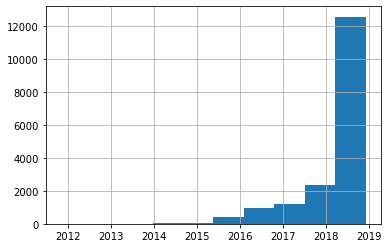

In [16]:
list_drop['last_review'].hist()

In [17]:
list_drop['last_review_year'] = list_drop['last_review'].apply(lambda x: x.strftime('%Y'))
list_drop

/var/folders/zs/fx_2z2p958g76_7y7tn94xp80000gn/T/ipykernel_13742/1689529064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_drop['last_review_year'] = list_drop['last_review'].apply(lambda x: x.strftime('%Y'))


,id,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,last_review_days,last_review_year
0,2818,Quiet Garden View Room & Super Fast WiFi,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,2018-11-28,2.10,44,8,2018
1,3209,"Quiet apt near center, great view",Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,2018-08-29,1.03,47,99,2018
2,20168,100%Centre-Studio 1 Private Floor/Bathroom,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,2018-11-30,2.18,198,6,2018
3,25428,Lovely apt in City Centre (Jordaan),Centrum-West,52.373114,4.883668,Entire home/apt,125,14,1,2018-01-21,0.09,141,319,2018
4,27886,"Romantic, stylish B&B houseboat in canal district",Centrum-West,52.386727,4.892078,Private room,150,2,171,2018-11-25,2.03,199,11,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19875,30435529,Amsterdam,De Baarsjes - Oud-West,52.365680,4.878104,Entire home/apt,85,2,1,2018-12-04,1.00,45,2,2018
19883,30439111,Cozy Studio,Oud-Noord,52.405705,4.891644,Entire home/apt,65,3,1,2018-12-02,1.00,9,4,2018
19966,30518120,1 Bedroom Apartment with Private Rooftop,Bos en Lommer,52.375726,4.851131,Entire home/apt,40,1,1,2018-12-04,1.00,155,2,2018
19975,30525429,★ On The RedLight Home ★,Centrum-West,52.373962,4.899847,Entire home/apt,212,4,1,2018-12-05,1.00,16,1,2018


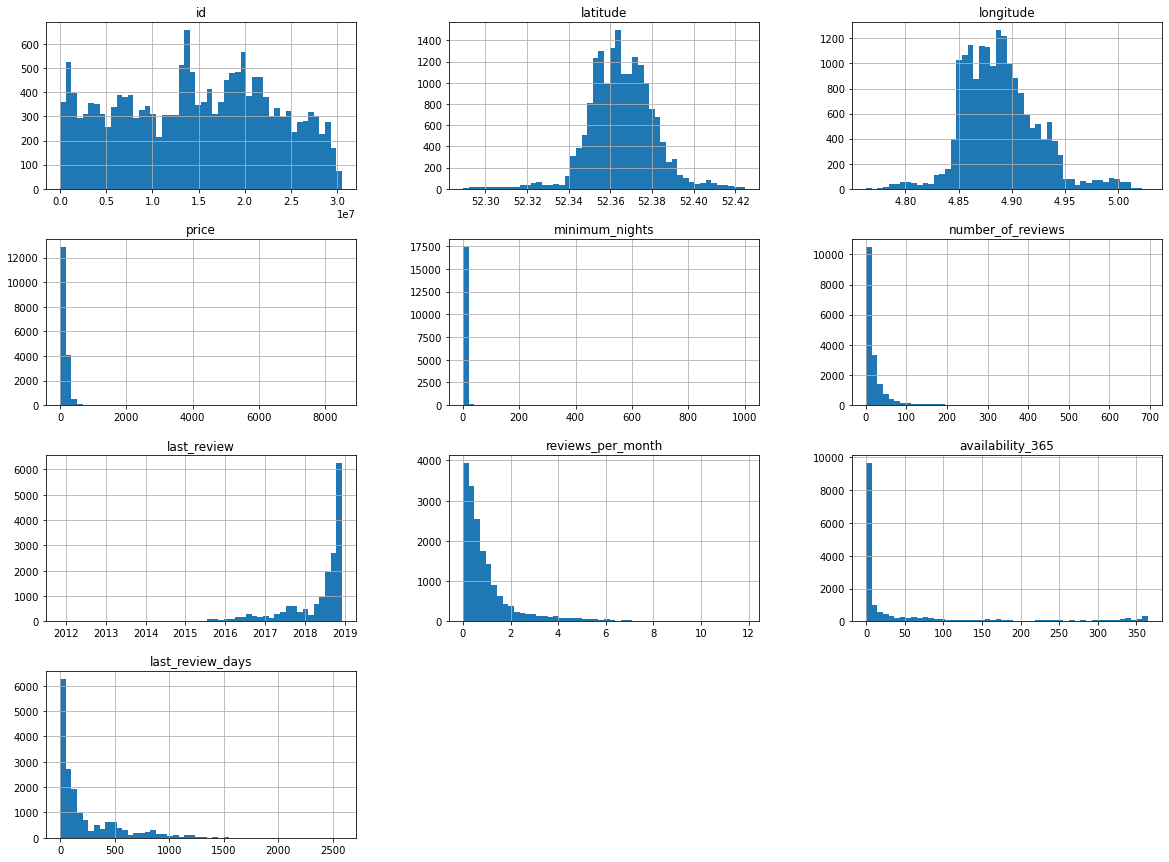

In [18]:
list_drop.hist(bins=50, figsize=(20,15))
plt.show()

In [19]:
list_drop.describe()

,id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,last_review_days
count,1.759700e+04,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000
mean,1.466169e+07,52.365360,4.888895,148.736432,3.174177,24.529067,1.063404,59.359266,231.948855
std,8.275956e+06,0.015860,0.035265,137.875133,12.430459,45.338129,1.333888,102.584119,298.669069
min,2.818000e+03,52.289274,4.763264,0.000000,1.000000,1.000000,0.010000,0.000000,0.000000
25%,7.551941e+06,52.355366,4.863703,96.000000,2.000000,4.000000,0.270000,0.000000,32.000000
50%,1.481737e+07,52.364782,4.886280,125.000000,2.000000,11.000000,0.620000,4.000000,102.000000
75%,2.121569e+07,52.375097,4.908164,175.000000,3.000000,25.000000,1.230000,68.000000,339.000000
max,3.055009e+07,52.424713,5.027689,8500.000000,1001.000000,695.000000,11.850000,365.000000,2584.000000


Here we can see that "minimum_nights" and "number_of_reviews" has outliers need to deal with

In [20]:
win = list_drop.copy()

s1 = win.minimum_nights
zscore = s1 - s1.mean()
win['outlier'] = zscore.abs() > 3 * s1.std()
win = win.drop(win[win.outlier == True].index)
win1 = win.drop(columns='outlier')

s2 = win1.number_of_reviews
zscore = s2 - s2.mean()
win1['outlier'] = zscore.abs() > 3 * s2.std()
win1 = win1.drop(win1[win1.outlier == True].index)
win2 = win1.drop(columns='outlier')

s3 = win2.price
zscore = s3 - s3.mean()
win2['outlier'] = zscore.abs() > 3 * s3.std()
win2 = win2.drop(win2[win2.outlier == True].index)
win3 = win2.drop(columns='outlier')

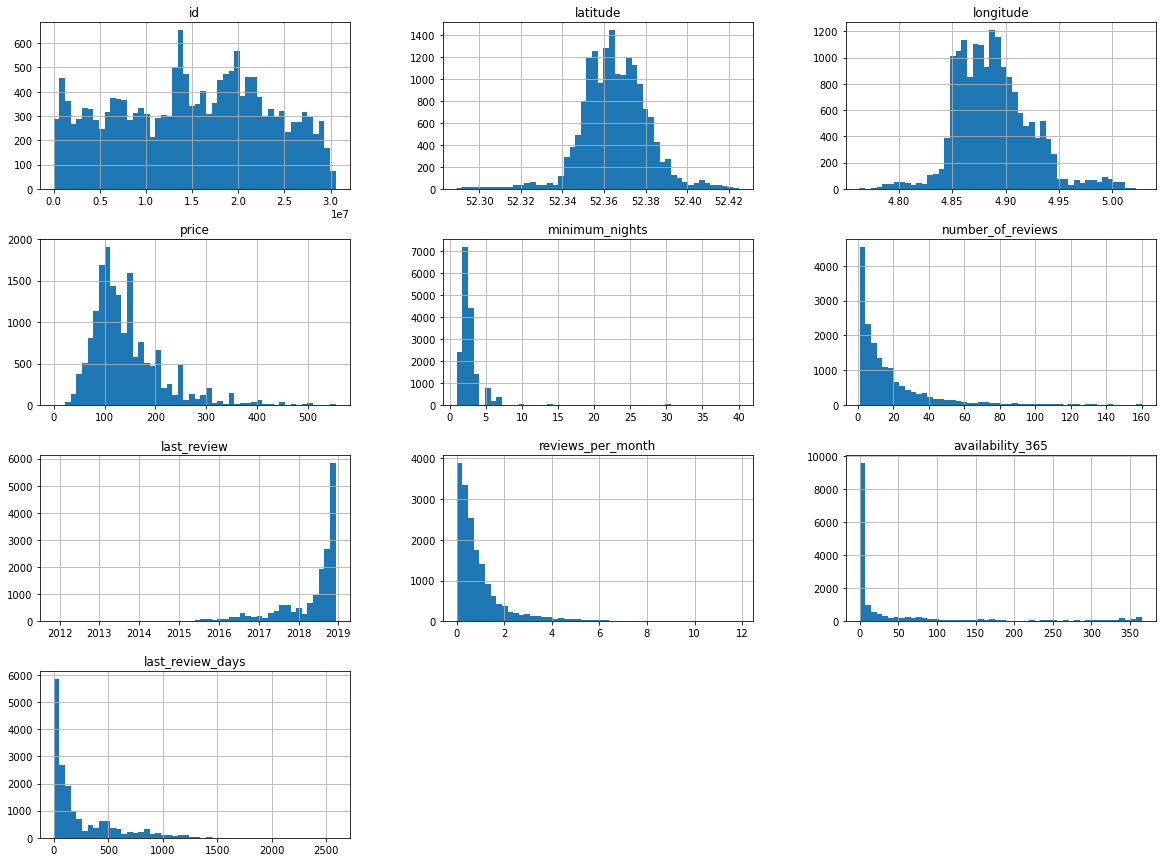

In [21]:
win3.hist(bins=50, figsize=(20,15))
plt.show()

In [22]:
win3.describe()

,id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,last_review_days
count,1.703300e+04,17033.000000,17033.000000,17033.000000,17033.000000,17033.000000,17033.000000,17033.000000,17033.000000
mean,1.491372e+07,52.365313,4.888859,144.190513,2.821406,19.111431,0.973129,55.505020,236.009863
std,8.189670e+06,0.015853,0.035351,73.207771,2.463171,24.849378,1.172412,99.513947,299.515215
min,3.209000e+03,52.289274,4.763264,0.000000,1.000000,1.000000,0.010000,0.000000,0.000000
25%,7.918225e+06,52.355314,4.863364,98.000000,2.000000,4.000000,0.270000,0.000000,35.000000
50%,1.513600e+07,52.364711,4.886137,125.000000,2.000000,10.000000,0.600000,3.000000,104.000000
75%,2.135158e+07,52.375089,4.908372,175.000000,3.000000,23.000000,1.160000,62.000000,349.000000
max,3.055009e+07,52.424713,5.027689,555.000000,40.000000,160.000000,11.850000,365.000000,2584.000000


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

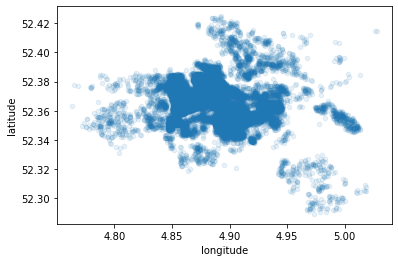

In [23]:
win3.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

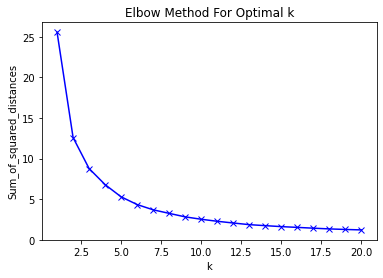

In [24]:
from sklearn.cluster import KMeans

#define function to find the best k number        
def fitting(df):
    Sum_of_squared_distances = []
    K = range(1,21)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(df)
        Sum_of_squared_distances.append(km.inertia_)
        #inertia_ reports the within group sum of squared errors, which is W in this Jupyter.
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return 

clust_source = win3[['longitude', 'latitude']]
fitting(clust_source)

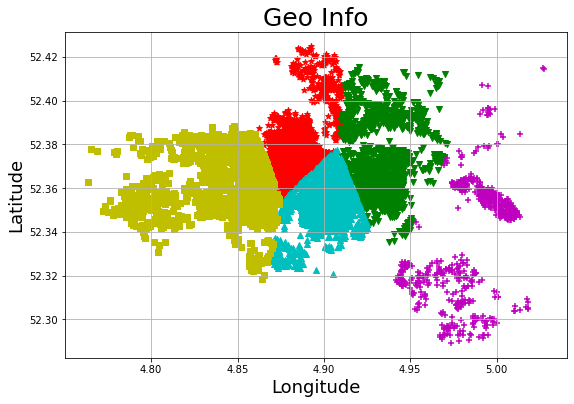

In [25]:
kmeans = KMeans(n_clusters=5, random_state=666, max_iter=1000,init='k-means++').fit(clust_source)
clust_source_np = np.array(clust_source)

markers = ['*', 'v', '+', '^', 's']   
colors = ['r', 'g', 'm', 'c', 'y'] 
labels = kmeans.labels_      

plt.figure(figsize=(9, 6))
plt.title("Geo Info", fontsize=25)
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)

for i in range(5):   
    members = labels == i      
    plt.scatter(
        clust_source_np[members, 0],      
        clust_source_np[members, 1],      
        marker = markers[i],   
        c = colors[i]         
    )   

plt.grid()
plt.show()

In [26]:
clust = win3.copy()
clust['clust'] = kmeans.labels_ 
clust

,id,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,last_review_days,last_review_year,clust
1,3209,"Quiet apt near center, great view",Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,2018-08-29,1.03,47,99,2018,0
3,25428,Lovely apt in City Centre (Jordaan),Centrum-West,52.373114,4.883668,Entire home/apt,125,14,1,2018-01-21,0.09,141,319,2018,0
8,31080,2-story apartment + rooftop terrace,Zuid,52.351321,4.848383,Entire home/apt,219,3,32,2017-10-16,0.36,336,416,2017,4
9,41125,Amsterdam Center Entire Apartment,Centrum-West,52.378915,4.883205,Entire home/apt,180,3,76,2018-10-07,0.78,11,60,2018,0
11,43980,View into park / museum district (long/short s...,Zuid,52.357456,4.861242,Entire home/apt,100,28,61,2018-02-18,0.62,10,291,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19875,30435529,Amsterdam,De Baarsjes - Oud-West,52.365680,4.878104,Entire home/apt,85,2,1,2018-12-04,1.00,45,2,2018,0
19883,30439111,Cozy Studio,Oud-Noord,52.405705,4.891644,Entire home/apt,65,3,1,2018-12-02,1.00,9,4,2018,0
19966,30518120,1 Bedroom Apartment with Private Rooftop,Bos en Lommer,52.375726,4.851131,Entire home/apt,40,1,1,2018-12-04,1.00,155,2,2018,4
19975,30525429,★ On The RedLight Home ★,Centrum-West,52.373962,4.899847,Entire home/apt,212,4,1,2018-12-05,1.00,16,1,2018,0


In [27]:
dummy = pd.get_dummies(clust,columns=['room_type','last_review_year'], drop_first=False)
dummy.columns

Index(['id', 'name', 'neighbourhood', 'latitude', 'longitude', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'availability_365', 'last_review_days', 'clust',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'last_review_year_2011',
       'last_review_year_2012', 'last_review_year_2013',
       'last_review_year_2014', 'last_review_year_2015',
       'last_review_year_2016', 'last_review_year_2017',
       'last_review_year_2018'],
      dtype='object')

In [28]:
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 22 22:49:20 2022

@author: hp
"""


import pandas as pd
import numpy as np
import os
import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from pandas import DataFrame, Series

data=dummy.copy()
data['name'] = data['name'].str.lower() #全部变为小写
sentences = data.iloc[:,1]
lines = sentences.tolist()
lines_=[]
for i in lines:
    lines1=word_tokenize(i)
    interpunctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&',
                         '!', '*', '@', '#', '$', '%','+','|','★','/','\\','``',
                         '★★★★★','1','2','3','4','5','\'s','\'','-','\\''']   #定义标点符号特殊字符
    lines2 = [word for word in lines1 if word not in interpunctuations]   #去除标点符号
    #lines3 = [PorterStemmer().stem(word) for word in lines2]
    lines4 = [word for word in lines2 if word not in stopwords.words('english')]
    lines_.append(lines4)
dictionary = {} #保存为最后的词频
for i in lines_:
    fredist = nltk.FreqDist(i) # 获取单文件词频
    for localkey in fredist.keys(): # 所有词频合并。 如果存在词频相加，否则添加
        if localkey in dictionary.keys(): # 检查当前词频是否在字典中存在
            dictionary[localkey] = dictionary[localkey] + fredist[localkey] # 如果存在，将词频累加，并更新字典值
                # print('--> 重复值：', localkey, dictionary[localkey])
        else: # 如果字典中不存在
            dictionary[localkey] = fredist[localkey] # 将当前词频添加到字典中
                # print('--> 新增值：', localkey, dictionary[localkey])


def filter(data):
    print(data.items())
    return {k: v for k, v in data.items() if v >= 50} #筛选词频

wd = filter(dictionary)
wd = DataFrame(Series(wd))
wd.to_excel('mid.xlsx',header=None)

[nltk_data] Downloading package punkt to /Users/xuanru/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xuanru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


dict_items([('quiet', 470), ('apt', 1029), ('near', 1486), ('center', 1357), ('great', 731), ('view', 774), ('lovely', 957), ('city', 1814), ('centre', 1631), ('jordaan', 593), ('2-story', 4), ('apartment', 6816), ('rooftop', 236), ('terrace', 642), ('amsterdam', 3820), ('entire', 49), ('park', 163), ('museum', 173), ('district', 148), ('long/short', 2), ('stay', 147), ('3-room', 6), ('cozy', 1107), ('flat', 176), ('loft', 326), ('central', 709), ('lot', 3), ('space', 53), ('luxurous', 4), ('houseboat-great', 1), ('location', 543), ('family', 877), ('home', 696), ('drugs', 1), ('smoking', 4), ('parties', 1), ('perfect', 286), ('bright', 990), ('residential', 7), ('area', 659), ('aqua', 1), ('luminous', 18), ('centric', 4), ('room', 1524), ('groundfloor', 49), ('patio', 34), ('greatly', 2), ('located', 243), ('atmosphere', 7), ('museumplein', 17), ('86', 1), ('m2', 62), ('still', 1), ('cosy', 1230), ('x', 3), ('mas', 1), ('availability', 3), ('en', 74), ('suite', 71), ('accommodation', 

In [29]:
count = pd.read_excel('mid.xlsx', header=None)
count.columns=['word', 'count']
count

,word,count
0,quiet,470
1,apt,1029
2,near,1486
3,center,1357
4,great,731
...,...,...
156,cs,54
157,centrally,74
158,persons,58
159,brand,56


In [30]:
a= count.query('count>1229')
a

,word,count
2,near,1486
3,center,1357
7,city,1814
8,centre,1631
10,apartment,6816
13,amsterdam,3820
29,room,1524
32,cosy,1230
37,house,1412
49,spacious,2028


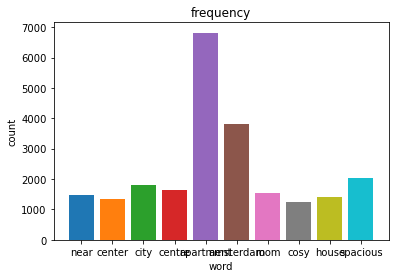

In [31]:
import matplotlib.pyplot as plt

for i in range(0,10):
    plt.bar(a.iloc[[i],[0]].values[0][0],a.iloc[[i],[1]].values[0][0])
plt.title('frequency')  #显示标题
plt.xlabel('word')                                   # 显示x轴名称
plt.ylabel('count')                                   # 显示y轴名称                          #显示图例
plt.show()   

In [32]:
name_list = ['near', 'center', 'city', 'centre', 'apartment', 'amsterdam', 'room', 'house', 'spacious', 'garden']
for names in name_list:
  b=0
  c=0
  a = dummy['name']
  b = a.str.contains(names, regex=False)
  c = b.astype(int)
  dummy[names] = c
dummy

,id,name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,...,near,center,city,centre,apartment,amsterdam,room,house,spacious,garden
1,3209,"Quiet apt near center, great view",Westerpark,52.390225,4.873924,160,4,42,2018-08-29,1.03,...,1,1,0,0,0,0,0,0,0,0
3,25428,Lovely apt in City Centre (Jordaan),Centrum-West,52.373114,4.883668,125,14,1,2018-01-21,0.09,...,0,0,0,0,0,0,0,0,0,0
8,31080,2-story apartment + rooftop terrace,Zuid,52.351321,4.848383,219,3,32,2017-10-16,0.36,...,0,0,0,0,1,0,0,0,0,0
9,41125,Amsterdam Center Entire Apartment,Centrum-West,52.378915,4.883205,180,3,76,2018-10-07,0.78,...,0,0,0,0,0,0,0,0,0,0
11,43980,View into park / museum district (long/short s...,Zuid,52.357456,4.861242,100,28,61,2018-02-18,0.62,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19875,30435529,Amsterdam,De Baarsjes - Oud-West,52.365680,4.878104,85,2,1,2018-12-04,1.00,...,0,0,0,0,0,0,0,0,0,0
19883,30439111,Cozy Studio,Oud-Noord,52.405705,4.891644,65,3,1,2018-12-02,1.00,...,0,0,0,0,0,0,0,0,0,0
19966,30518120,1 Bedroom Apartment with Private Rooftop,Bos en Lommer,52.375726,4.851131,40,1,1,2018-12-04,1.00,...,0,0,0,0,0,0,1,0,0,0
19975,30525429,★ On The RedLight Home ★,Centrum-West,52.373962,4.899847,212,4,1,2018-12-05,1.00,...,0,0,0,0,0,0,0,0,0,0


In [33]:
dummy.to_csv('preprocess.csv')

## Causal inference

In [34]:
import statsmodels.api as sm

In [35]:
df = pd.read_csv("preprocess.csv")
df.columns

Index(['Unnamed: 0', 'id', 'name', 'neighbourhood', 'latitude', 'longitude',
       'price', 'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'availability_365', 'last_review_days', 'clust',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'last_review_year_2011',
       'last_review_year_2012', 'last_review_year_2013',
       'last_review_year_2014', 'last_review_year_2015',
       'last_review_year_2016', 'last_review_year_2017',
       'last_review_year_2018', 'near', 'center', 'city', 'centre',
       'apartment', 'amsterdam', 'room', 'house', 'spacious', 'garden'],
      dtype='object')

In [36]:
df = pd.get_dummies(df,columns=['neighbourhood'],drop_first = False)

In [39]:
df.columns

Index(['Unnamed: 0', 'id', 'name', 'latitude', 'longitude', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'availability_365', 'last_review_days', 'clust',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'last_review_year_2011',
       'last_review_year_2012', 'last_review_year_2013',
       'last_review_year_2014', 'last_review_year_2015',
       'last_review_year_2016', 'last_review_year_2017',
       'last_review_year_2018', 'near', 'center', 'city', 'centre',
       'apartment', 'amsterdam', 'room', 'house', 'spacious', 'garden',
       'neighbourhood_Bijlmer-Centrum', 'neighbourhood_Bijlmer-Oost',
       'neighbourhood_Bos en Lommer', 'neighbourhood_Buitenveldert - Zuidas',
       'neighbourhood_Centrum-Oost', 'neighbourhood_Centrum-West',
       'neighbourhood_De Aker - Nieuw Sloten',
       'neighbourhood_De Baarsjes - Oud-West',
       'neighbourhood_De Pijp - Rivierenbuurt',
      

In [40]:
def balance_check(df,y,x):
    result= pd.DataFrame()
    for i in y:
        for j in x:
            #pvalue= pd.DataFrame()
            BalanceCheck_treatment = sm.OLS(endog = df[i], exog = sm.add_constant(df[j]))
            result_BC = BalanceCheck_treatment.fit()
            pvalue = result_BC.pvalues.reset_index().round(1).iloc[1:]
            pvalue.insert(0,'y',i)
            pvalue.insert(2,'coef',result_BC.params[1])
            result= pd.concat([result,pvalue])
    result.rename(columns={0:'p_value','index':'x'},inplace=True)
    result.reset_index(drop=True,inplace=True)
    result['balance or not']=result['p_value']>0.05
    return result

In [41]:
y=['price']
x=['clust','price','last_review_year_2011',
       'last_review_year_2012', 'last_review_year_2013',
       'last_review_year_2014', 'last_review_year_2015',
       'last_review_year_2016', 'last_review_year_2017',
       'last_review_year_2018','last_review_days',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'near', 'center', 'city', 'centre',
       'apartment', 'amsterdam', 'room', 'house', 'spacious', 'garden',
   'minimum_nights', 'number_of_reviews','reviews_per_month',
  'neighbourhood_Bijlmer-Centrum', 'neighbourhood_Bijlmer-Oost',
       'neighbourhood_Bos en Lommer', 'neighbourhood_Buitenveldert - Zuidas',
       'neighbourhood_Centrum-Oost', 'neighbourhood_Centrum-West',
       'neighbourhood_De Aker - Nieuw Sloten',
       'neighbourhood_De Baarsjes - Oud-West',
       'neighbourhood_De Pijp - Rivierenbuurt',
       'neighbourhood_Gaasperdam - Driemond',
       'neighbourhood_Geuzenveld - Slotermeer',
       'neighbourhood_IJburg - Zeeburgereiland', 'neighbourhood_Noord-Oost',
       'neighbourhood_Noord-West',
       'neighbourhood_Oostelijk Havengebied - Indische Buurt',
       'neighbourhood_Osdorp', 'neighbourhood_Oud-Noord',
       'neighbourhood_Oud-Oost', 'neighbourhood_Slotervaart',
       'neighbourhood_Watergraafsmeer', 'neighbourhood_Westerpark',
       'neighbourhood_Zuid']
bc_full=balance_check(df,y,x)
bc_full

/Users/xuanru/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/xuanru/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/xuanru/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/xuanru/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/xuanru/opt/anaconda3/lib/pyth

,y,x,coef,p_value,balance or not
0,price,clust,-4.727579,0.0,False
1,price,price,1.000000,0.0,False
2,price,last_review_year_2011,115.816287,0.1,True
3,price,last_review_year_2012,25.815550,0.5,True
4,price,last_review_year_2013,21.221947,0.4,True
5,price,last_review_year_2014,-19.725799,0.1,True
6,price,last_review_year_2015,-14.379171,0.0,False
7,price,last_review_year_2016,-20.302879,0.0,False
8,price,last_review_year_2017,-11.508786,0.0,False
9,price,last_review_year_2018,16.947819,0.0,False


In [42]:
regress_list=[]
for i in range(len(bc_full)):
    if bc_full.iloc[i,4]==False:
        regress_list.append(bc_full.iloc[i,1])
regress_list

['clust',
 'price',
 'last_review_year_2015',
 'last_review_year_2016',
 'last_review_year_2017',
 'last_review_year_2018',
 'last_review_days',
 'room_type_Entire home/apt',
 'room_type_Private room',
 'room_type_Shared room',
 'near',
 'city',
 'centre',
 'apartment',
 'room',
 'house',
 'spacious',
 'garden',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'neighbourhood_Bijlmer-Centrum',
 'neighbourhood_Bijlmer-Oost',
 'neighbourhood_Bos en Lommer',
 'neighbourhood_Buitenveldert - Zuidas',
 'neighbourhood_Centrum-Oost',
 'neighbourhood_Centrum-West',
 'neighbourhood_De Aker - Nieuw Sloten',
 'neighbourhood_De Baarsjes - Oud-West',
 'neighbourhood_De Pijp - Rivierenbuurt',
 'neighbourhood_Gaasperdam - Driemond',
 'neighbourhood_Geuzenveld - Slotermeer',
 'neighbourhood_IJburg - Zeeburgereiland',
 'neighbourhood_Noord-Oost',
 'neighbourhood_Noord-West',
 'neighbourhood_Oostelijk Havengebied - Indische Buurt',
 'neighbourhood_Osdorp',
 'neighbourhood_Oud-Noord',
 'neig

In [43]:
df = pd.read_csv("preprocess.csv")
df = pd.get_dummies(df,columns=['neighbourhood'],drop_first = False)
df['365']=df['availability_365']<50

In [45]:
df['365']=df['365'].astype(int)
df['365']

0        1
1        0
2        0
3        1
4        1
        ..
17028    1
17029    1
17030    0
17031    1
17032    1
Name: 365, Length: 17033, dtype: int64

In [46]:
df.columns

Index(['Unnamed: 0', 'id', 'name', 'latitude', 'longitude', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'availability_365', 'last_review_days', 'clust',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'last_review_year_2011',
       'last_review_year_2012', 'last_review_year_2013',
       'last_review_year_2014', 'last_review_year_2015',
       'last_review_year_2016', 'last_review_year_2017',
       'last_review_year_2018', 'near', 'center', 'city', 'centre',
       'apartment', 'amsterdam', 'room', 'house', 'spacious', 'garden',
       'neighbourhood_Bijlmer-Centrum', 'neighbourhood_Bijlmer-Oost',
       'neighbourhood_Bos en Lommer', 'neighbourhood_Buitenveldert - Zuidas',
       'neighbourhood_Centrum-Oost', 'neighbourhood_Centrum-West',
       'neighbourhood_De Aker - Nieuw Sloten',
       'neighbourhood_De Baarsjes - Oud-West',
       'neighbourhood_De Pijp - Rivierenbuurt',
      

In [47]:
from sklearn.model_selection import train_test_split as tr_te_split

X = df[['availability_365','last_review_year_2011',
       'last_review_year_2012', 'last_review_year_2013',
       'last_review_year_2014', 'last_review_year_2015',
       'last_review_year_2016', 'last_review_year_2017',
       'last_review_year_2018','last_review_days',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'near', 'center', 'city', 'centre',
       'apartment', 'amsterdam', 'room', 'house', 'spacious', 'garden','minimum_nights', 
                     'number_of_reviews','reviews_per_month',
                    'neighbourhood_Bijlmer-Centrum', 'neighbourhood_Bijlmer-Oost',
       'neighbourhood_Bos en Lommer', 'neighbourhood_Buitenveldert - Zuidas',
       'neighbourhood_Centrum-Oost', 'neighbourhood_Centrum-West',
       'neighbourhood_De Aker - Nieuw Sloten',
       'neighbourhood_De Baarsjes - Oud-West',
       'neighbourhood_De Pijp - Rivierenbuurt',
       'neighbourhood_Gaasperdam - Driemond',
       'neighbourhood_Geuzenveld - Slotermeer',
       'neighbourhood_IJburg - Zeeburgereiland', 'neighbourhood_Noord-Oost',
       'neighbourhood_Noord-West',
       'neighbourhood_Oostelijk Havengebied - Indische Buurt',
       'neighbourhood_Osdorp', 'neighbourhood_Oud-Noord',
       'neighbourhood_Oud-Oost', 'neighbourhood_Slotervaart',
       'neighbourhood_Watergraafsmeer', 'neighbourhood_Westerpark',
       'neighbourhood_Zuid']]
y = df['price']
X_train, X_test, y_train, y_test = tr_te_split(X, y, test_size=0.3)

## Data modelling

In [48]:
def mae(y_test,y_pred):
    mae = sum(abs(y_test-y_pred))/len(y_pred)
    return mae

### 1. lightgbm

In [49]:
import lightgbm as lgbm
from sklearn import metrics
from sklearn import model_selection

gbm = lgbm.LGBMRegressor(
    objective='regression',
    max_depth=5,
    num_leaves=50,
    learning_rate=0.01,
    n_estimators=1000,
    metric='mae',
)
gbm_model= gbm.fit(X_train,y_train)

In [50]:
pred_gbm = gbm_model.predict(X_test)
mae_lgbm = mae(y_test,pred_gbm)
mae_lgbm

43.729570489007806

### 2. xgboost

In [51]:
import xgboost as xgb
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bynode=0.8,\
                          learning_rate = 0.05, gamma = 0.001,max_depth = 7,  n_estimators = 50)
from sklearn.metrics import mean_squared_error as mse
xgb_reg.fit(X_train,y_train)
preds_xgbt = xgb_reg.predict(X_test)

In [52]:
mae_xgbt = mae(y_test,preds_xgbt)
mae_xgbt

42.800699059324025

In [53]:
pd.DataFrame(list(xgb_reg.get_booster().get_score(importance_type='gain').items()),columns=['features','importance']).sort_values(by='importance',ascending=False).head(10)

,features,importance
8,room_type_Entire home/apt,1.016606e+06
9,room_type_Private room,2.225469e+05
29,neighbourhood_Centrum-West,1.437088e+05
18,house,9.348308e+04
28,neighbourhood_Centrum-Oost,9.268608e+04
0,availability_365,5.624689e+04
35,neighbourhood_IJburg - Zeeburgereiland,4.278630e+04
32,neighbourhood_De Pijp - Rivierenbuurt,4.246003e+04
45,neighbourhood_Zuid,4.168281e+04
26,neighbourhood_Bos en Lommer,4.078999e+04


### 3. random forest

In [54]:
from sklearn.ensemble import RandomForestRegressor
forest=RandomForestRegressor(n_estimators=250,
                             random_state=1)
forest.fit(X_train,y_train)
preds_RN = forest.predict(X_test)

In [55]:
mae_RN = mae(y_test,preds_RN)
mae_RN

46.03950163078935

In [56]:
a=pd.DataFrame({'features':X_train.columns,
                'importance':forest.feature_importances_})
a=a.sort_values(by='importance',ascending=False)
a.head(10)

,features,importance
9,last_review_days,0.166005
0,availability_365,0.164192
25,reviews_per_month,0.145861
24,number_of_reviews,0.114003
10,room_type_Entire home/apt,0.100973
23,minimum_nights,0.059826
31,neighbourhood_Centrum-West,0.029718
30,neighbourhood_Centrum-Oost,0.021275
20,house,0.020336
17,apartment,0.018313


### 4. gredient boosting tree

In [57]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=100,max_depth=6,learning_rate = 0.05)
gbr.fit(X_train,y_train)
preds_gdbt = gbr.predict(X_test)
mae_gdbt = mae(y_test,preds_gdbt)
mae_gdbt

43.977966925642704

In [58]:
b=pd.DataFrame({'features':X_train.columns,
                'importance':gbr.feature_importances_})
b=b.sort_values(by='importance',ascending=False)
b.head(10)

,features,importance
10,room_type_Entire home/apt,0.254785
0,availability_365,0.223800
9,last_review_days,0.082992
31,neighbourhood_Centrum-West,0.077777
25,reviews_per_month,0.053577
30,neighbourhood_Centrum-Oost,0.049012
20,house,0.048850
24,number_of_reviews,0.039633
23,minimum_nights,0.032148
47,neighbourhood_Zuid,0.016803


### 5. Linear model

In [59]:
from sklearn.linear_model import LinearRegression as LinReg

reg = LinReg(fit_intercept=True).fit(X_train, y_train)
pred_linreg = reg.predict(X_test)
mae_Linear = mae(y_test,pred_linreg)
mae_Linear

44.757245590590436

### 6. Lasso Ridge ElasticNet

In [60]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

In [61]:
#ridge
ridge = Ridge()
ridge.fit(X_train,y_train)
pred_ridge = ridge.predict(X_test)
mae_ridge = mae(pred_ridge,y_test)
mae_ridge

44.7546165593229

In [62]:
#lasso
lasso = Lasso()
lasso.fit(X_train,y_train)
pred_lasso = lasso.predict(X_test)
mae_lasso = mae(pred_lasso,y_test)
mae_lasso

45.51914258467341

In [63]:
#elastic net
elasticnet = ElasticNet()
elasticnet.fit(X_train,y_train)
pred_elasticnet = elasticnet.predict(X_test)
mae_elastic = mae(pred_elasticnet,y_test)
mae_elastic

48.76433920883112

## model comparsion

In [64]:
linear_model_list = {'ridge': ridge,
                     'lasso':lasso,
                     'elasticnet':elasticnet,
                     'linear_model':reg
                    }
nonlinear_model_list = {'GradientBoosting': gbr,
                       'XGBoosting': xgb_reg,
                        'Random_forest':forest,
                        'Lightgbm': gbm_model
                       }

In [65]:
feature_importance = []
for model_name, model in linear_model_list.items():
    feature_importance.append(model.coef_)
for model_name, model in nonlinear_model_list.items():
    feature_importance.append(model.feature_importances_)
feature_importance = pd.DataFrame(feature_importance, columns=X_train.columns)
feature_importance.index = list(linear_model_list.keys()) + list(nonlinear_model_list.keys())

In [66]:
def return_most_important_features(features_importance, top):
    features_sorted = features_importance.sort_values(ascending=False)
    return features_sorted.index.values[0:top]

In [67]:
features_sorted = []
for ind in np.arange(feature_importance.shape[0]):
    features_sorted.append(return_most_important_features(feature_importance.iloc[ind, :], top=10))

In [68]:
def return_columns(top):
    indicators = ['st', 'nd', 'rd']

    columns = []
    for ind in np.arange(top):
        try:
            columns.append('{}{} Important Feature'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Important Feature'.format(ind+1))
    return columns

In [69]:
features_sorted = pd.DataFrame(features_sorted, columns=return_columns(top=10))
features_sorted.index = feature_importance.index
features_sorted

,1st Important Feature,2nd Important Feature,3rd Important Feature,4th Important Feature,5th Important Feature,6th Important Feature,7th Important Feature,8th Important Feature,9th Important Feature,10th Important Feature
ridge,neighbourhood_Centrum-West,last_review_year_2013,room_type_Entire home/apt,neighbourhood_Centrum-Oost,house,neighbourhood_Zuid,neighbourhood_De Pijp - Rivierenbuurt,neighbourhood_IJburg - Zeeburgereiland,spacious,neighbourhood_De Baarsjes - Oud-West
lasso,room_type_Entire home/apt,neighbourhood_Centrum-West,neighbourhood_Centrum-Oost,house,neighbourhood_De Pijp - Rivierenbuurt,neighbourhood_Zuid,availability_365,last_review_year_2017,last_review_year_2018,last_review_year_2014
elasticnet,room_type_Entire home/apt,neighbourhood_Centrum-West,house,neighbourhood_Centrum-Oost,neighbourhood_De Pijp - Rivierenbuurt,neighbourhood_Zuid,availability_365,neighbourhood_Bijlmer-Oost,neighbourhood_Oud-Noord,neighbourhood_Geuzenveld - Slotermeer
linear_model,last_review_year_2013,neighbourhood_Centrum-West,room_type_Entire home/apt,neighbourhood_Centrum-Oost,house,neighbourhood_Zuid,neighbourhood_De Pijp - Rivierenbuurt,neighbourhood_IJburg - Zeeburgereiland,spacious,neighbourhood_De Baarsjes - Oud-West
GradientBoosting,room_type_Entire home/apt,availability_365,last_review_days,neighbourhood_Centrum-West,reviews_per_month,neighbourhood_Centrum-Oost,house,number_of_reviews,minimum_nights,neighbourhood_Zuid
XGBoosting,room_type_Entire home/apt,room_type_Private room,neighbourhood_Centrum-West,house,neighbourhood_Centrum-Oost,availability_365,neighbourhood_IJburg - Zeeburgereiland,neighbourhood_De Pijp - Rivierenbuurt,neighbourhood_Zuid,neighbourhood_Bos en Lommer
Random_forest,last_review_days,availability_365,reviews_per_month,number_of_reviews,room_type_Entire home/apt,minimum_nights,neighbourhood_Centrum-West,neighbourhood_Centrum-Oost,house,apartment
Lightgbm,availability_365,last_review_days,reviews_per_month,number_of_reviews,minimum_nights,neighbourhood_Centrum-West,room_type_Entire home/apt,neighbourhood_Centrum-Oost,house,room


In [70]:
mae_all = [mae_ridge,mae_lasso,mae_elastic,mae_Linear,mae_gdbt,mae_xgbt,mae_RN,mae_lgbm]
mae_all = pd.DataFrame(
            {'algorithm':np.array(list(linear_model_list.keys()) + list(nonlinear_model_list.keys())), 
             'mae': mae_all}
             )
mae_all

,algorithm,mae
0,ridge,44.754617
1,lasso,45.519143
2,elasticnet,48.764339
3,linear_model,44.757246
4,GradientBoosting,43.977967
5,XGBoosting,42.800699
6,Random_forest,46.039502
7,Lightgbm,43.729570
